# Deep Otello AI

The game reversi is a very good game to apply deep learning methods to.

Othello also known as reversi is a board game first published in 1883 by eiter Lewis Waterman or John W. Mollet in England (each one was denouncing the other as fraud).
It is a strickt turn based zero-sum game with a clear Markov chain and now hidden states like in card games with an unknown distribution of cards or unknown player allegiance.
There is like for the game go only one set of stones with two colors which is much easier to abstract than chess with its 6 unique pieces.
The game has a symmetrical game board wich allows to play with rotating the state around an axis to allow for a breaking of sequences or interesting ANN architectures, quadruple the data generation by simulation or interesting test cases where a symetry in turns should be observable if the AI reaches an "objective" policy.


## Content

* [The game rules](#the-game-rules) A short overview over the rules of the game.
* [Some common Otello strategies](#some-common-otello-strategies) introduces some easy approaches to a classic Otello AI and defines some behavioral expectations.
* [Initial design decisions](#initial-design-decisions) an explanation about some initial design decision and assumptions
* [Imports and dependencies](#imports-and-dependencies) explains what libraries where used


## The game rules

Othello is played on a board with 8 x 8 fields for two player.
The board geometry is equal to a chess game.
The game is played with game stones that are black on one siede and white on the other.
![Othello game board example](reversi_example.png)
The player take turns.
A player places a stone with his or her color up on the game board.
The player can only place stones when he surrounds a number of stones with the opponents color with the new stone and already placed stones of his color.
Those surrounded stones can either be horizontally, vertically and/or diagonally be placed.
All stones thus surrounded will be flipped to be of the players color.
Turns are only possible if the player is also changing the color of the opponents stones. If a player can't act he is skipped.
The game ends if both players can't act. The player with the most stones wins.
If the score is counted in detail unclaimed fields go to the player with more stones of his or her color on the board.
The game begins with four stones places in the center of the game. Each player gets two. They are placed diagonally to each other.


![Startaufstellung.png](Startaufstellung.png)

## Some common Othello strategies

As can be easily understood the placement of stones and on the bord is always a careful balance of attack and defence.
If the player occupies huge homogenous stretches on the board it can be attacked easier.
The boards corners provide safety from wich occupied territory is impossible to loos but since it is only possible to reach the corners if the enemy is forced to allow this or calculates the cost of giving a stable base to the enemy it is difficult to obtain.
There are some text on otello computer strategies which implement greedy algorithms for reversi based on a modified score to each field.
Those different values are score modifiers for a traditional greedy algorithm.
If a players stone has captured such a filed the score reached is multiplied by the modifier.
The total score is the score reached by the player subtracted with the score of the enemy.
The scores change in the course of the game and converges against one. This gives some indications of what to expect from an Othello AI.

![ComputerPossitionScore](computer-score.png)


## Initial design decisions

At the beginning of this project I made some design decisions.
The first onw was that I do not want to use a gym library because it limits the data formats accessible.
I choose to implement the hole game as entry in a stack in numpy arrays to be able to accommodate interfacing with a neural network easier and to use scipy pattern recognition tools to implement some game mechanics for a fast simulation cycle.
I chose to ignore player colors as far as I could instead a player perspective was used. Which allowed to change the perspective with a flipping of the sign. (multiplying with -1).
The array format should also allow for data multiplication or the breaking of strikt sequences by flipping the game along one the for axis, (horizontal, vertical, transpose along both diagonals).

I wanted to implement different agents as classes that act on those game stacks.

In [1]:
%load_ext blackcellmagic

## Imports and dependencies

The following direct dependencies where used for this project:
```toml
jupyter = "^1.0.0"
matplotlib = "^3.6.3"
numpy = "^1.24.1"
pytest = "^7.2.1"
python = "3.10.*"
scipy = "^1.10.0"
tqdm = "^4.64.1"
jupyterlab = "^3.6.1"
torchvision = "^0.14.1"
torchaudio = "^0.13.1"
```
* `Jupyter` and `jupyterlab` on pycharm was used as a IDE / Ipython was used to implement this code.
* `matplotlib` was used for visualisation and statistics.
* `numpy` was used for array support and mathematical functions
* `tqdm` was used for progress bars
* `scipy` contains fast pattern recognition tools for images. It was used to make an initial estimation about where possible turns should be.
* `torch` supplied the ANN functionalities.

In [27]:
import numpy as np
import abc
from typing import Final
from scipy.ndimage import binary_dilation
import matplotlib.pyplot as plt
from abc import ABC

## Constants

Some general constants needed to be defined. Such as board game size and Player and Enemy representations. Also, directional offsets and the initial placement of blocks.

In [24]:
BOARD_SIZE: Final[int] = 8  # defines the board side length as 8
PLAYER: Final[int] = 1  # defines the number symbolising the player as 1
ENEMY: Final[int] = -1  # defines the number symbolising the enemy as -1

The directions array contains all the numerical offsets needed to move along one of the 8 directions in a 2 dimensional grid. This will allow an iteration over the game board.
![8-directions.png](8-directions.png "Offset in 8 directions")

In [26]:
DIRECTIONS: Final[np.ndarray] = np.array(
    [[i, j] for i in range(-1, 2) for j in range(-1, 2) if j != 0 or i != 0],
    dtype=int,
)
DIRECTIONS.setflags(write=False)
DIRECTIONS

array([[-1, -1],
       [-1,  0],
       [-1,  1],
       [ 0, -1],
       [ 0,  1],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1]])

Another constant needed is the initial start square at the center of the board.

In [23]:
START_SQUARE: Final[np.ndarray] = np.array(
    [[ENEMY, PLAYER], [PLAYER, ENEMY]], dtype=int
)
START_SQUARE.setflags(write=False)
START_SQUARE

array([[-1,  1],
       [ 1, -1]])

## Creating new boards

The first function implemented and tested is a function to generate the starting environment as a stack of games.
As described above I simply placed a 2 by 2 square in the center of an empty stack of boards.

In [6]:
def get_new_games(number_of_games: int) -> np.ndarray:
    """Generates a stack of initialised game boards.

    Args:
        number_of_games: The size of the board stack.

    Returns: The generates stack of games as a stack n x 8 x 8.

    """
    empty = np.zeros([number_of_games, BOARD_SIZE, BOARD_SIZE], dtype=int)
    empty[:, 3:5, 3:5] = START_SQUARE
    return empty


get_new_games(1)[0]

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  1,  0,  0,  0],
       [ 0,  0,  0,  1, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [7]:
test_number_of_games = 3
assert get_new_games(test_number_of_games).shape == (
    test_number_of_games,
    BOARD_SIZE,
    BOARD_SIZE,
)
np.testing.assert_equal(
    get_new_games(test_number_of_games).sum(axis=1),
    np.zeros(
        [
            test_number_of_games,
            8,
        ]
    ),
)
np.testing.assert_equal(
    get_new_games(test_number_of_games).sum(axis=2),
    np.zeros(
        [
            test_number_of_games,
            8,
        ]
    ),
)
assert np.all(get_new_games(test_number_of_games)[:, 3:4, 3:4] != 0)
del test_number_of_games

## Visualisation tools

In this section a visualisation help was implemented for debugging of the game and a proper display of the results.
For this visualisation ChatGPT was used as a prompted code generator that was later reviewed and refactored by hand to integrate seamlessly into the project as a whole.

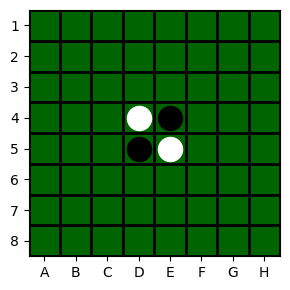

In [8]:
def plot_othello_board(board, ax=None) -> None:
    """Plots a single otello board.

    If a matplot axis object is given the board will be plotted into that axis. If not an axis object will be generated.

    Args:
        board: The bord that should be plotted. Only a single games is allowed. A numpy array of the form 8x8 is expected.
        ax: If needed the

    """
    plot_all = False
    if ax is None:
        fig_size = 3
        plot_all = True
        fig, ax = plt.subplots(figsize=(fig_size, fig_size))

    ax.set_facecolor("#006400")
    for i in range(BOARD_SIZE):
        for j in range(BOARD_SIZE):
            if board[i, j] == -1:
                color = "white"
            elif board[i, j] == 1:
                color = "black"
            else:
                continue
            ax.scatter(j, i, s=300 if plot_all else 150, c=color)
    for i in range(-1, 8):
        ax.axhline(i + 0.5, color="black", lw=2)
        ax.axvline(i + 0.5, color="black", lw=2)
    ax.set_xlim(-0.5, 7.5)
    ax.set_ylim(7.5, -0.5)
    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(list("ABCDEFGH"))
    ax.set_yticks(np.arange(8))
    ax.set_yticklabels(list("12345678"))
    if plot_all:
        plt.tight_layout()
        plt.show()


plot_othello_board(get_new_games(1)[0])

In [9]:
def plot_othello_boards(boards: np.ndarray) -> None:
    assert boards.shape[0] < 70
    plots_per_row = 4
    rows = int(np.ceil(boards.shape[0] / plots_per_row))
    fig, axs = plt.subplots(rows, plots_per_row, figsize=(12, 3 * rows))
    for game_index, ax in enumerate(axs.flatten()):
        if game_index >= boards.shape[0]:
            fig.delaxes(ax)
        else:
            plot_othello_board(boards[game_index], ax)
    plt.tight_layout()
    plt.show()

In [10]:
SURROUNDING: Final = np.array([[[1, 1, 1], [1, 0, 1], [1, 1, 1]]])
SURROUNDING

array([[[1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]]])

In [11]:
def recursive_steps(_array, rec_direction, rec_position, step_one=True) -> bool:
    rec_position = rec_position + rec_direction
    if np.any((rec_position >= BOARD_SIZE) | (rec_position < 0)):
        return False
    next_field = _array[tuple(rec_position.tolist())]
    if next_field == 0:
        return False
    if next_field == -1:
        return recursive_steps(_array, rec_direction, rec_position, step_one=False)
    if next_field == 1:
        return not step_one


def get_possible_turns(boards: np.ndarray) -> np.ndarray:
    try:
        _poss_turns = boards == 0
        _poss_turns &= binary_dilation(boards == -1, SURROUNDING)
    except RuntimeError as err:
        print(boards)
        print(boards == -1)
        print("err")
        raise err
    for game in range(boards.shape[0]):
        for idx in range(BOARD_SIZE):
            for idy in range(BOARD_SIZE):

                position = idx, idy
                if _poss_turns[game, idx, idy]:
                    _poss_turns[game, idx, idy] = any(
                        recursive_steps(boards[game, :, :], direction, position)
                        for direction in DIRECTIONS
                    )
    return _poss_turns


# %timeit get_possible_turns(get_new_games(10))
# %timeit get_possible_turns(get_new_games(100))
get_possible_turns(get_new_games(3))[:1]

array([[[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False,  True, False, False, False, False],
        [False, False,  True, False, False, False, False, False],
        [False, False, False, False, False,  True, False, False],
        [False, False, False, False,  True, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]]])

In [12]:
def board_evaluation_final(array: np.ndarray):
    score1, score2 = np.sum(array == 1, axis=(1, 2)), np.sum(array == -1, axis=(1, 2))
    player_1_won = score1 > score2
    player_2_won = score1 < score2
    score1_final = 64 - score2[player_1_won]
    score2_final = 64 - score1[player_2_won]
    score1[player_1_won] = score1_final
    score2[player_2_won] = score2_final
    return score1, score2


def board_evaluation(array: np.ndarray):
    score1, score2 = np.sum(array == 1, axis=(1, 2)), np.sum(array == -1, axis=(1, 2))
    return score1, score2


board_evaluation(get_new_games(3))
board_evaluation_final(get_new_games(3))

(array([2, 2, 2]), array([2, 2, 2]))

In [13]:
def move_possible(board: np.ndarray, move: np.ndarray) -> bool:
    if np.all(move == -1):
        return not np.any(get_possible_turns(np.reshape(board, (1, 8, 8))))
    return any(
        recursive_steps(board[:, :], direction, move) for direction in DIRECTIONS
    )


assert move_possible(get_new_games(1)[0], np.array([2, 3])) is True
assert move_possible(get_new_games(1)[0], np.array([3, 2])) is True
assert move_possible(get_new_games(1)[0], np.array([2, 2])) is False
assert move_possible(np.zeros((8, 8)), np.array([3, 2])) is False
assert move_possible(np.ones((8, 8)) * 1, np.array([-1, -1])) is True
assert move_possible(np.ones((8, 8)) * -1, np.array([-1, -1])) is True
assert move_possible(np.ones((8, 8)) * 0, np.array([-1, -1])) is True

In [14]:
def moves_possible(boards: np.ndarray, moves: np.ndarray) -> np.ndarray:
    arr_moves_possible = np.zeros(boards.shape[0], dtype=bool)
    for game in range(boards.shape[0]):
        if np.all(moves[game] == -1):
            arr_moves_possible[game] = not np.any(
                get_possible_turns(np.reshape(boards[game], (1, 8, 8)))
            )
        else:
            arr_moves_possible[game] = any(
                recursive_steps(boards[game, :, :], direction, moves[game])
                for direction in DIRECTIONS
            )
    return arr_moves_possible


np.testing.assert_array_equal(
    moves_possible(np.ones((3, 8, 8)) * 1, np.array([[-1, -1]] * 3)),
    np.array([True] * 3),
)

np.testing.assert_array_equal(
    moves_possible(get_new_games(3), np.array([[2, 3], [3, 2], [3, 2]])),
    np.array([True] * 3),
)
np.testing.assert_array_equal(
    moves_possible(get_new_games(3), np.array([[2, 2], [1, 1], [0, 0]])),
    np.array([False] * 3),
)
np.testing.assert_array_equal(
    moves_possible(np.ones((3, 8, 8)) * -1, np.array([[-1, -1]] * 3)),
    np.array([True] * 3),
)
np.testing.assert_array_equal(
    moves_possible(np.zeros((3, 8, 8)), np.array([[-1, -1]] * 3)),
    np.array([True] * 3),
)

In [15]:
class InvalidTurn(ValueError):
    pass


def do_moves(boards: np.ndarray, moves: np.ndarray) -> np.ndarray:
    def _do_directional_move(
        board: np.ndarray, rec_move: np.ndarray, rev_direction, step_one=True
    ) -> bool:
        rec_position = rec_move + rev_direction
        if np.any((rec_position >= 8) | (rec_position < 0)):
            return False
        next_field = board[tuple(rec_position.tolist())]
        if next_field == 0:
            return False
        if next_field == 1:
            return not step_one
        if next_field == -1:
            if _do_directional_move(board, rec_position, rev_direction, step_one=False):
                board[tuple(rec_position.tolist())] = 1
                return True
            return False

    def _do_move(_board: np.ndarray, move: np.ndarray) -> None:
        if np.all(move == -1):
            return
        if _board[tuple(move.tolist())] != 0:
            raise InvalidTurn
        action = False
        for direction in DIRECTIONS:
            if _do_directional_move(_board, move, direction):
                action = True
        if not action:
            raise InvalidTurn()
        _board[tuple(move.tolist())] = 1

    boards = boards.copy()
    for game in range(boards.shape[0]):
        _do_move(boards[game], moves[game])
    return boards


do_moves(get_new_games(10), np.array([[2, 3]] * 10))[0]

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  1, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [16]:
class GamePolicy(ABC):

    IMPOSSIBLE: np.ndarray = np.array([-1, -1], dtype=int)

    @property
    @abc.abstractmethod
    def policy_name(self) -> str:
        raise NotImplementedError()

    @abc.abstractmethod
    def internal_policy(self, boards: np.ndarray) -> np.ndarray:
        raise NotImplementedError()

    def get_policy(self, boards: np.ndarray) -> np.ndarray:
        policies = self.internal_policy(boards)
        possible_turns = get_possible_turns(boards)
        policies[possible_turns == False] = -1.0
        max_indices = [
            np.unravel_index(policy.argmax(), policy.shape) for policy in policies
        ]
        policy_vector = np.array(max_indices)

        no_turn_possible = np.all(policy_vector == 0, 1) & (policies[:, 0, 0] == -1.0)

        policy_vector[no_turn_possible] = GamePolicy.IMPOSSIBLE
        return policy_vector

In [17]:
class RandomPolicy(GamePolicy):
    @property
    def policy_name(self) -> str:
        return "random"

    def internal_policy(self, boards: np.ndarray) -> np.ndarray:
        random_values = np.random.rand(*boards.shape)
        return random_values
        # return np.argmax(random_values, (1, 2))


rnd_policy = RandomPolicy()
assert rnd_policy.policy_name == "random"
rnd_policy_result = rnd_policy.get_policy(get_new_games(1))
assert np.any((5 >= rnd_policy_result) & (rnd_policy_result >= 3))

In [18]:
def single_turn(
    current_boards: np, policy: GamePolicy
) -> tuple[np.ndarray, np.ndarray]:
    policy_results = policy.get_policy(current_boards)

    assert np.all(moves_possible(current_boards, policy_results)), (
        current_boards[(moves_possible(current_boards, policy_results) == False)],
        policy_results[(moves_possible(current_boards, policy_results) == False)],
        np.where(moves_possible(current_boards, policy_results) == False),
    )

    return do_moves(current_boards, policy_results), policy_results


%timeit single_turn(get_new_games(100), RandomPolicy())
single_turn(get_new_games(100), RandomPolicy())[0]

123 ms ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [19]:
SIMULATE_TURNS = 70


def simulate_game(
    nr_of_games: int,
    policies: tuple[GamePolicy, GamePolicy],
) -> tuple[np.ndarray, np.ndarray]:

    board_history_stack = np.zeros((SIMULATE_TURNS, nr_of_games, 8, 8))
    action_history_stack = np.zeros((SIMULATE_TURNS, nr_of_games, 2))
    current_boards = get_new_games(nr_of_games)
    for turn_index in range(SIMULATE_TURNS):
        policy_index = turn_index % 2
        policy = policies[policy_index]
        board_history_stack[turn_index] = current_boards
        if policy_index == 0:
            current_boards = current_boards * -1
        current_boards, action_taken = single_turn(current_boards, policy)
        action_history_stack[turn_index] = action_taken

        if policy_index == 0:
            current_boards = current_boards * -1

    return board_history_stack, action_history_stack


%timeit simulate_game(100, (RandomPolicy(), RandomPolicy()))
simulate_game(10, (RandomPolicy(), RandomPolicy()))

10.8 s ± 339 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
         ...,
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  

In [20]:
import numpy as np


def create_test_game():
    test_array = [
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 0, 0, 0],
            [0, 0, 0, 2, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 0, 0, 0],
            [0, 0, 0, 2, 2, 0, 0, 0],
            [0, 0, 0, 2, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 0, 0, 0],
            [0, 0, 0, 2, 2, 0, 0, 0],
            [0, 0, 1, 1, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 0, 0, 0],
            [0, 0, 0, 2, 2, 0, 0, 0],
            [0, 0, 2, 1, 1, 0, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 0, 0, 0],
            [0, 0, 2, 1, 1, 0, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 0, 0, 0],
            [0, 0, 2, 1, 1, 0, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 0, 0, 0],
            [0, 0, 2, 2, 2, 2, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 1, 0, 0],
            [0, 0, 2, 2, 2, 2, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 2, 2, 0, 0],
            [0, 0, 2, 2, 2, 2, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 2, 2, 0, 0],
            [0, 0, 2, 2, 1, 2, 0, 0],
            [0, 2, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 2, 2, 0, 0],
            [0, 0, 2, 2, 1, 2, 0, 0],
            [0, 2, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 2, 2, 0, 0],
            [0, 1, 1, 1, 1, 2, 0, 0],
            [0, 2, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 2, 2, 0, 0],
            [2, 2, 2, 2, 2, 2, 0, 0],
            [0, 2, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 1, 1, 1, 0],
            [2, 2, 2, 2, 2, 2, 0, 0],
            [0, 2, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 1, 1, 1, 0],
            [2, 2, 2, 1, 2, 2, 0, 0],
            [0, 2, 0, 1, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 2, 2, 0, 0],
            [0, 0, 0, 2, 2, 1, 1, 0],
            [2, 2, 2, 1, 2, 2, 0, 0],
            [0, 2, 0, 1, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 1, 0, 0],
            [0, 0, 0, 2, 2, 1, 0, 0],
            [0, 0, 0, 2, 2, 1, 1, 0],
            [2, 2, 2, 1, 2, 2, 0, 0],
            [0, 2, 0, 1, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 1, 0, 0],
            [0, 0, 0, 2, 2, 2, 2, 0],
            [0, 0, 0, 2, 2, 2, 1, 0],
            [2, 2, 2, 1, 2, 2, 0, 0],
            [0, 2, 0, 1, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 1, 0, 0],
            [0, 0, 0, 2, 1, 2, 2, 0],
            [0, 0, 0, 2, 2, 1, 1, 0],
            [2, 2, 2, 1, 1, 1, 1, 0],
            [0, 2, 0, 1, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 1, 0, 0],
            [0, 0, 0, 2, 1, 2, 2, 0],
            [0, 0, 0, 2, 2, 1, 2, 0],
            [2, 2, 2, 2, 2, 2, 2, 2],
            [0, 2, 0, 1, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 1, 0, 0],
            [0, 0, 0, 2, 1, 2, 2, 0],
            [0, 0, 0, 2, 1, 1, 2, 0],
            [2, 2, 2, 2, 1, 2, 2, 2],
            [0, 2, 0, 1, 1, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 2, 0, 0, 0],
            [0, 0, 2, 2, 0, 2, 0, 0],
            [0, 0, 0, 2, 1, 2, 2, 0],
            [0, 0, 0, 2, 1, 1, 2, 0],
            [2, 2, 2, 2, 1, 2, 2, 2],
            [0, 2, 0, 1, 1, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
    ]
    test_array = np.array(test_array)

    # swapp 2 by one. 2 was only there for homogenous formating and easier readability while coading.
    test_array[test_array == 2] = -1
    assert np.all(
        np.count_nonzero(test_array, axis=(1, 2))
        == np.arange(4, 4 + test_array.shape[0])
    )

    # validated that only one stone is added per turn
    zero_array = test_array == 0
    diff = zero_array != np.roll(zero_array, 1, axis=0)
    turns = np.where(diff[1:])
    arr = np.array(turns)[0]
    assert len(arr) == len(set(arr))

    return test_array

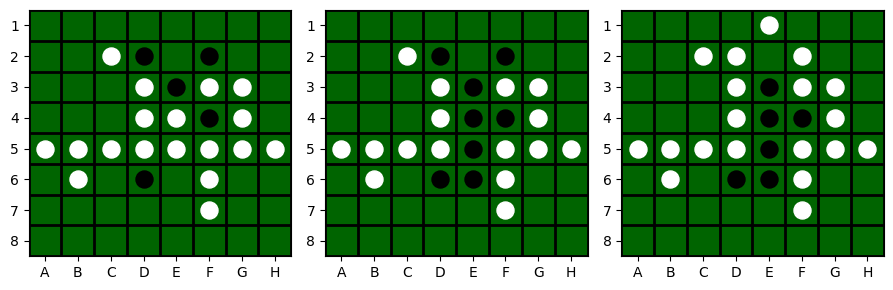

In [21]:
plot_othello_boards(create_test_game()[-3:])

In [22]:
array = create_test_game()

# Sources

* Game rules and example board images [https://en.wikipedia.org/wiki/Reversi](https://en.wikipedia.org/wiki/Reversi)
* Game rules and example game images [https://de.wikipedia.org/wiki/Othello_(Spiel)](https://de.wikipedia.org/wiki/Othello_(Spiel))
* Game strategy examples [https://de.wikipedia.org/wiki/Computer-Othello](https://de.wikipedia.org/wiki/Computer-Othello)
* Image for 8 directions [https://www.researchgate.net/journal/EURASIP-Journal-on-Image-and-Video-Processing-1687-5281](https://www.researchgate.net/journal/EURASIP-Journal-on-Image-and-Video-Processing-1687-5281)